In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math 

def weights_init(init_type='gaussian'):
    def init_fun(m):
        classname = m.__class__.__name__
        if (classname.find('Conv') == 0 or classname.find(
                'Linear') == 0) and hasattr(m, 'weight'):
            if init_type == 'gaussian':
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight, gain=math.sqrt(2))
            elif init_type == 'default':
                pass
            else:
                assert 0, "Unsupported initialization: {}".format(init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

    return init_fun


class ViTModel(nn.Module):
    def __init__(self, vit_model_type = 'dino_vitb16'):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/dino:main', vit_model_type)
        self.model.head = nn.Identity()

    def forward(self, x):
        feats = []
        
        def hook(module, input, output):
            feats.append(output)
        
        id = self.model.blocks[-1].register_forward_hook(hook)
        _ = self.model(x)
        id.remove()

        return feats[-1]
    

class Decoder(nn.Module):
    def __init__(self,in_channels,output_resolution=224, out_channels = 3):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels // 2, 3, 2),
            nn.ConvTranspose2d(in_channels // 2, in_channels // 4, 3, 2),
            nn.ConvTranspose2d(in_channels // 4, in_channels // 8, 3, 2),
            nn.ConvTranspose2d(in_channels // 8, in_channels // 16, 3, 2),
            nn.ConvTranspose2d(in_channels // 16, 32, 3, 2),
            nn.ConvTranspose2d(32, 3, 3, 2),
            nn.Upsample(size=(output_resolution,output_resolution), align_corners=True, mode='bilinear')
        )

    def forward(self, x):
        return self.decoder(x)
    

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.out_dim = num_classes

        self.network = nn.Sequential(
            nn.Linear(num_classes, 32),
            nn.Linear(32, 16),
            nn.Linear(16,1)
        )


    def forward(self, x):
        return self.network(x)
    
# Discriminator(768, 40)(torch.randn(2,768)).shape

# Discriminator(40)(torch.rand(14,40)).shape
ViTModel()(torch.rand(1,3,224,224)).shape

Using cache found in /Users/sarthakm/.cache/torch/hub/facebookresearch_dino_main


torch.Size([1, 197, 768])

vit -> cls token -> into the decoder for inpainting
for every image -> one pos and neg (one closest and one furthest) (through kmeans clustering?) (pos->nearest in the batch and viceversa)
repeat the cls token -> patched image cls token + actual image cls token -> decoder -> reconstruction loss
masked_image and pos_image cls token + masked_image + neg_image cls token



vit (last layer is trainable) -> cls token (all 4) -> decoder -> 3 recontructed images ( wrt to the original image)

original_image - 1 
masked_image - 2
pos - 3
neg - 4

ct1 + ct2 -> recontructed iamge- > l1 with original
ct2 + ct3 -> recontructed wrt pos -> margin loss
ct2 + ct4 -> reconstructed wrt neg -> margin loss

first see tsne

evaluating: kmeans output along with 3 metrics

problem definition

architechture detail

loss functions

literature survey

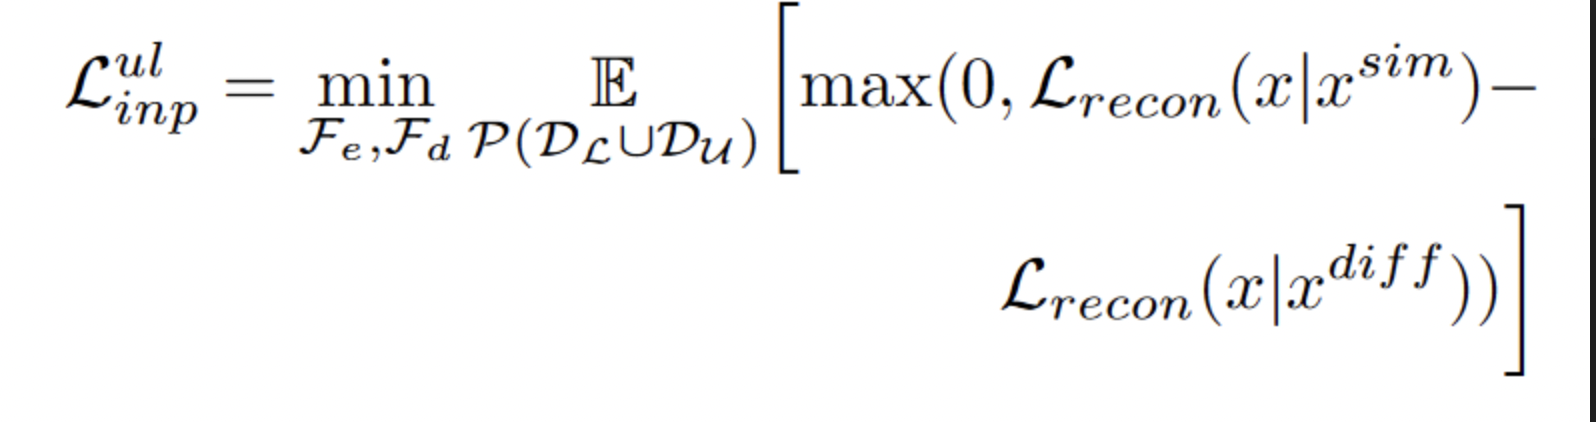

In [15]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd 
from torchvision import transforms


def create_random_mask(min_size, max_size, image_size):
    mask_size = torch.randint(min_size, max_size + 1, (2,))
    x = torch.randint(0, image_size[0] - mask_size[0], (1,))
    y = torch.randint(0, image_size[1] - mask_size[1], (1,))
    mask = torch.ones(image_size)
    mask[x[0]:x[0]+mask_size[0], y[0]:y[0]+mask_size[1]] = 0
    return mask

class dataset(Dataset):
    def __init__(self, csv_path, image_size = 512, mask_min_size = 60, mask_max_size = 200):
        csv = pd.read_csv(csv_path)
        self.images = csv['images'].values
        self.image_size = image_size
        self.mask_min_size = mask_min_size
        self.mask_max_size = mask_max_size
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.Resize((image_size,image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        mask = create_random_mask(self.mask_min_size, self.mask_max_size, (self.image_size,self.image_size))
        image = self.transform(Image.open(self.images[idx]))
        masked_image = mask*image 
        return masked_image, mask.unsqueeze(0), image

In [16]:
from torchvision import models
import torch
from torch import nn
from torch.nn import functional as F

class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        vgg16 = models.vgg16(pretrained=True)

        self.enc_1 = nn.Sequential(*vgg16.features[:5])
        self.enc_2 = nn.Sequential(*vgg16.features[5:10])
        self.enc_3 = nn.Sequential(*vgg16.features[10:17])

        # fix the encoder
        for i in range(3):
            for param in getattr(self, 'enc_{:d}'.format(i + 1)).parameters():
                param.requires_grad = False

    def forward(self, image):
        results = [image]
        for i in range(3):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]
    

def gram_matrix(feat):
    # https://github.com/pytorch/ex`amples/blob/master/fast_neural_style/neural_style/utils.py
    (b, ch, h, w) = feat.size()
    feat = feat.view(b, ch, h * w)
    feat_t = feat.transpose(1, 2)
    gram = torch.bmm(feat, feat_t) / (ch * h * w)
    return gram


def total_variation_loss(image):
    # shift one pixel and get difference (for both x and y direction)
    loss = torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
        torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))
    return loss

class InpaintingLoss(nn.Module):
    def __init__(self, extractor=VGG16FeatureExtractor()):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.extractor = extractor

    def forward(self, mask, output, gt):
        loss_dict = {}
        loss_dict['hole'] = self.l1((1 - mask) * output, (1 - mask) * gt)
        loss_dict['valid'] = self.l1(mask * output, mask * gt)
        feat_output = self.extractor(output)
        feat_gt = self.extractor(gt)
        loss_dict['prc'] = 0.0
        for i in range(3):
            loss_dict['prc'] += self.l1(feat_output[i], feat_gt[i])
        loss_dict['style'] = 0.0
        for i in range(3):
            loss_dict['style'] += self.l1(gram_matrix(feat_output[i]),
                                          gram_matrix(feat_gt[i]))

        # loss_dict['tv'] = total_variation_loss(output_comp)
            
        return loss_dict

/Users/sarthakm/miniconda3/envs/inpainting/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sarthakm/miniconda3/envs/inpainting/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm


device = 'mps'
dataloader = DataLoader(dataset('data/painting_train.csv'), batch_size=4, shuffle = True)

model = UNet(3,3,bilinear=True).to(device)
loss_fn = InpaintingLoss().to(device)
optim = torch.optim.Adam(model.parameters())

for epoch in range(50):
    for idx, (masked_image, labelled_or_not, image) in enumerate(tqdm(dataloader)):
        labelled_or_not = labelled_or_not.to(device)
        masked_image = masked_image.to(device)
        image = image.to(device)

        output = model(masked_image)

        losses = loss_fn(labelled_or_not, output, image)
        loss = 0
        for k,v in losses.items():
            loss += v

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        torch.save({'model':model.state_dict()},f'checkpoint_{epoch}.pth')


### Losses

In [10]:
num_classes = 40

import torch 
from torch import nn
from torch.nn import functional as F 

y = torch.tensor([1/num_classes for _ in range(num_classes)])

In [11]:
features = torch.rand(2,786)
centers = torch.rand(num_classes,786)

cos = []

for i in range(num_classes):
    cos.append(nn.CosineSimilarity(dim = -1)(features, centers[i,:]).unsqueeze(1))

In [12]:
# cos = F.normalize(torch.concat(cos, dim = 1), p = 1, dim = 1)
cos = F.softmax(torch.concat(cos, dim = 1), dim=1)

cos.shape

torch.Size([2, 40])

In [13]:
y = y.expand(2,-1)

In [14]:
torch.sum(-y*torch.log(cos))

tensor(7.3778)

In [3]:
import torch
from torch import nn
from torch.nn import functional as F

num_classes = 40

features = torch.rand(32,768)
centers = torch.rand(num_classes,768)
labels = torch.randint(low=0, high = 40,size=(32,))
labelled_or_not = torch.randint(low=0, high=2,size=(32,)).to(torch.bool)

In [4]:
features_temp = features[labelled_or_not]
labels_temp = labels[labelled_or_not]

In [5]:
cos = []

for i in range(num_classes):
    cos.append(nn.CosineSimilarity(dim = -1)(features_temp, centers[i,:]).unsqueeze(1))
cos_2 = F.cosine_similarity(features_temp.unsqueeze(1), centers, dim = 2)

In [6]:
cos_2.shape

torch.Size([16, 40])

In [7]:
cos_dist_with_centers = torch.concat(cos, dim = -1)

In [10]:
cos_dist_with_centers.shape

torch.Size([12, 40])

In [250]:
labels_temp

tensor([15, 26, 11, 12, 12,  5, 10, 28, 31, 16, 26,  1, 29])

In [14]:
positions = -1 + torch.zeros(len(labels_temp), num_classes)
for i,pos in enumerate(labels_temp):
    positions[i,pos] = 1

In [17]:
positions_2 = torch.zeros(len(labels_temp), num_classes) + -1
(positions_2.scatter_(1, labels_temp.unsqueeze(1), 1) == positions).all()

tensor(True)

In [252]:
(cos_dist_with_centers*positions).shape

torch.Size([13, 40])

In [253]:
-torch.sum(cos_dist_with_centers*positions)

tensor(371.2588)

In [254]:
torch.sum(F.normalize(cos_dist_with_centers*positions, p=1, dim=1))

tensor(-12.3504)

In [257]:
from model import ViTModel


ViTModel().model.embed_dim

Using cache found in /Users/sarthakm/.cache/torch/hub/facebookresearch_dino_main


768

In [17]:
import torch
import os
from os.path import join
import pandas as pd
from PIL import Image

def create_random_mask(min_size, max_size, image_size):
    mask_size = torch.randint(min_size, max_size + 1, (2,))
    x = torch.randint(0, image_size[0] - mask_size[0], (1,))
    y = torch.randint(0, image_size[1] - mask_size[1], (1,))
    mask = torch.ones(image_size)
    mask[x[0]:x[0]+mask_size[0], y[0]:y[0]+mask_size[1]] = 0
    return mask



dataset_dir = '/Users/sarthakm/Desktop/biplabsir_research/OfficeHomeDataset'

for folder in os.listdir(dataset_dir):
    if os.path.isdir(join(dataset_dir, folder)):
        for category in os.listdir(join(dataset_dir,folder)):
            if os.path.isdir(join(dataset_dir, folder, category)):
                for image in os.listdir(join(dataset_dir, folder, category)):
                    torch.save(
                        create_random_mask(image_size=(224,224), min_size = 25, max_size = 75),
                        join(dataset_dir, folder, category, f'{image.split(".")[0]}.pt')
                    )


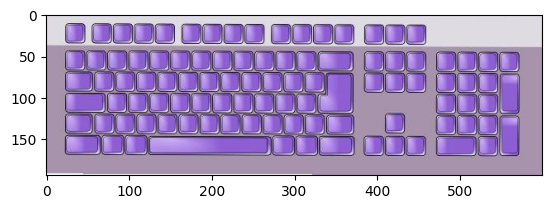

In [11]:
import numpy as np

plt.imshow(np.array(image))

In [12]:
np.array(image).shape

(194, 600, 3)

### Pairing with positive and negatives

In [18]:
import pandas as pd
import os
from os.path import join

dataset_dir = '/Users/sarthakm/Desktop/biplabsir_research/OfficeHomeDataset'

file = 'test.csv'
for file in ['test.csv', 'train.csv', 'train_2.csv', 'val.csv']:

    df = pd.read_csv(join(dataset_dir, file))

    df['image'] = df['image'].apply(lambda x: x.replace('_10072016', ''))

    same_labels = []
    diff_labels = []
    for i in range(len(df)):
        row = df.iloc[i]
        df_temp = df.drop(i)
        same_labels.append(df_temp[df_temp['label'] == row['label']].sample(n = 1)['image'].values[0])
        diff_labels.append(df_temp[df_temp['label'] != row['label']].sample(n=1)['image'].values[0])

    df['pos'] = same_labels
    df['neg'] = diff_labels
    df['mask'] = df['image'].apply(lambda x: x.split('.')[0] + '.pt')
    df.to_csv(join(dataset_dir, file), index = False)

### Dataloader

In [19]:
from data.officehome import OfficeHome

data = OfficeHome()

result = data.__getitem__(2000)

for i in range(len(data)):
    try:
        data.__getitem__(i)
    except:
        print(i)